In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plot
import os
import time
from sklearn.metrics import f1_score

In [2]:
batchSize = 64
learningRate = 0.001
epochCount = 15

In [3]:
from google.colab import drive
drive.mount('/content/drive')
dataset = ImageFolder("/content/drive/MyDrive/Garbage classification/Garbage classification", transform=torchvision.transforms.ToTensor())
trainDataset, validationDataset, testDataset = random_split(dataset, [1769, 379, 379])

trainDataLoader = DataLoader(trainDataset, batchSize, shuffle = True)
validationDataLoader = DataLoader(validationDataset, batchSize)
testDataLoader = DataLoader(testDataset, batchSize)

Mounted at /content/drive


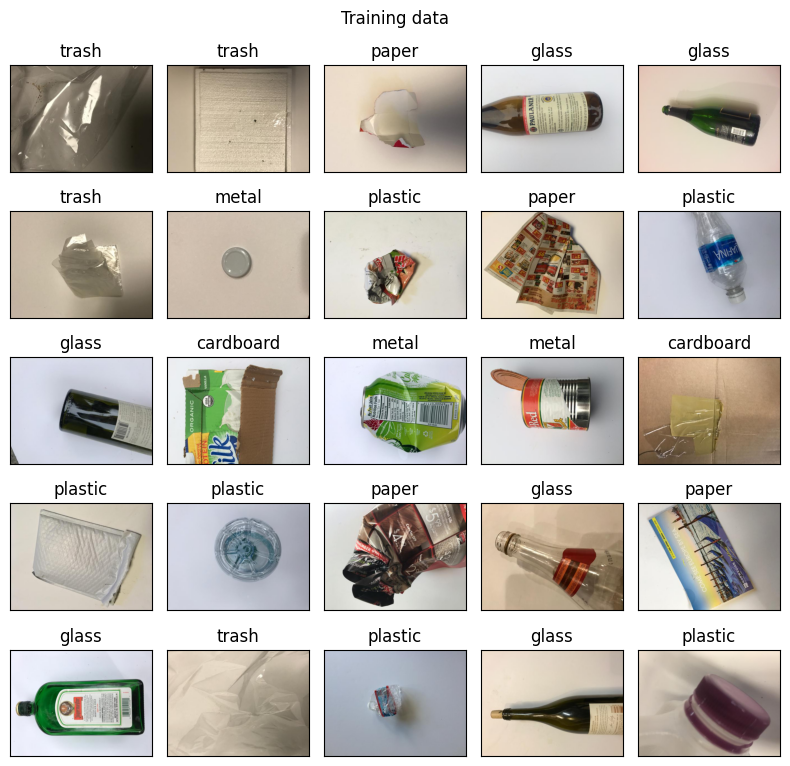

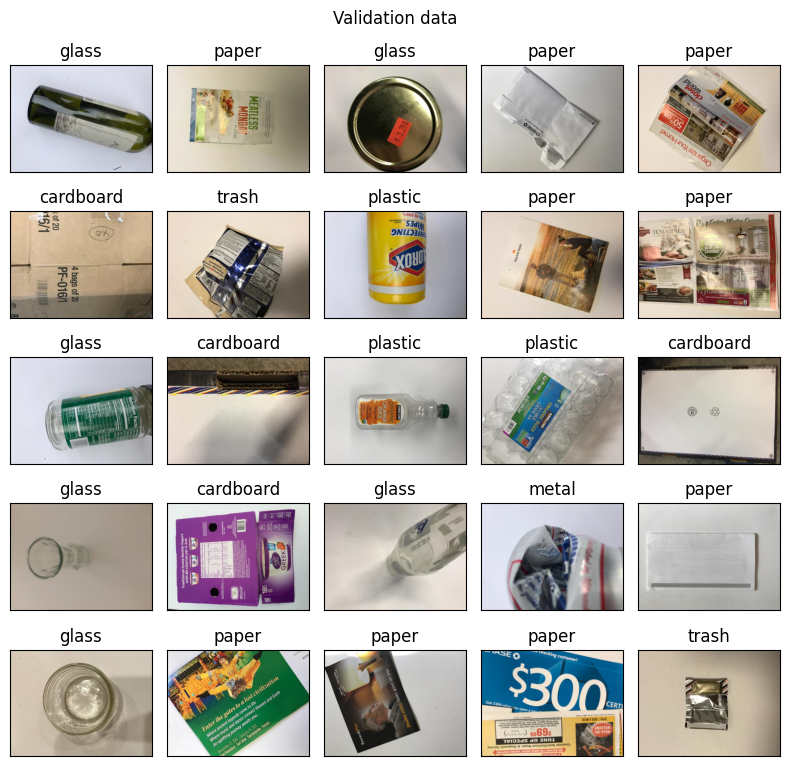

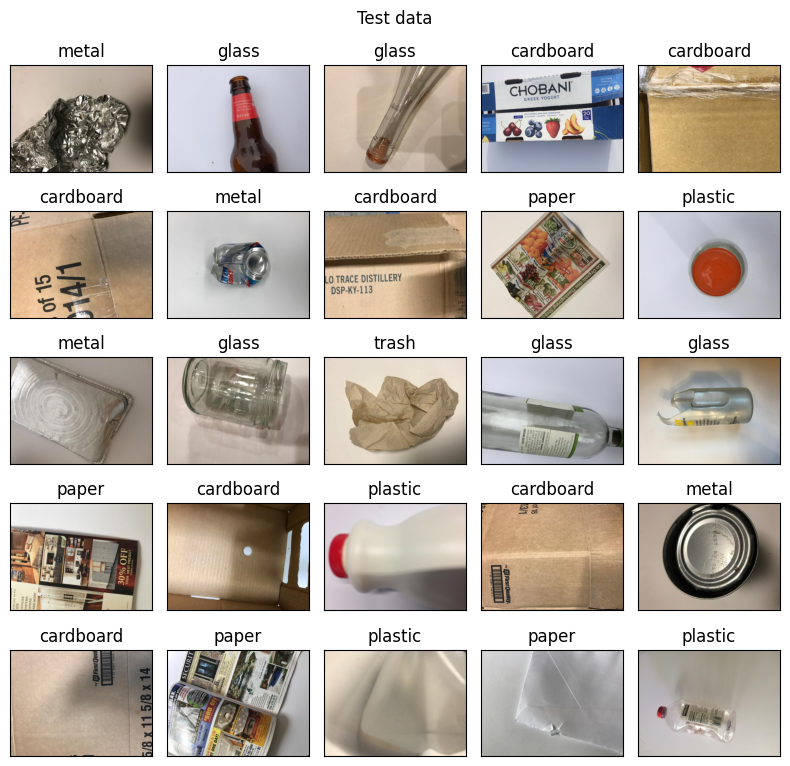

In [4]:
def showImages(title, images):
    imgsCount = 5

    fig, axes = plot.subplots(imgsCount, imgsCount, figsize = (8,8))
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks=[], yticks=[])

    for i, axes in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0)
        axes.imshow(img)
        axes.set_title(dataset.classes[images[i][1]])
        plot.tight_layout()

showImages('Training data', trainDataset)
showImages('Validation data', validationDataset)
showImages('Test data', testDataset)

In [5]:
def ResNet50_def(num_classes: int):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def ResNet50_mod(num_classes: int):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes),
    )
    return model

def VGG16_def(num_classes: int):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.features[-6:].parameters():
        param.requires_grad = True
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    return model

def VGG16_mod(num_classes: int):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.features[24:].parameters():
        param.requires_grad = True
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((7, 7)),
    )
    model.classifier = nn.Sequential(
        nn.Linear(256 * 7 * 7, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, num_classes)
    )
    return model

def GoogleNet_def(num_classes: int):

    model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def GoogleNet_mod(num_classes: int):
    model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.inception5b.parameters():
        param.requires_grad = True
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model

def ShuffleNet_def(num_classes: int):
    model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def ShuffleNet_mod(num_classes: int):
    model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, num_classes)
    )
    return model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
lossFunction = torch.nn.CrossEntropyLoss()

cuda:0


In [7]:
def F1score(model, dataLoader):
  f1_list = []
  model = model.to(device)
  with torch.no_grad():
    for images, labels in dataLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        f1_list.append(f1)
  return sum(f1_list) / len(f1_list)

In [8]:
f1_test_table = []

def train(modelTrain, data, validationDataLoader):
  optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, modelTrain.parameters()), lr=learningRate)
  startTime = time.time()
  f1_list = []
  for epoch in range(epochCount):
    epochTimeStart = time.time()
    lossEpoch = []
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = modelTrain(images)
        loss = lossFunction(outputs, labels)
        lossEpoch.append(loss)

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: loss = {torch.stack(lossEpoch).mean():.4f}, time = {time.time() - epochTimeStart:.4f} s", flush=True)

    validationTimeStart = time.time()
    f1_all = []
    with torch.no_grad():
      for images, labels in validationDataLoader:
          images, labels = images.to(device), labels.to(device)
          outputs = modelTrain(images)
          _, preds = torch.max(outputs, 1)
          f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
          f1_all.append(f1)
    val_f1 = F1score(modelTrain, validationDataLoader)
    f1_list.append(val_f1)
    print(f"Validation: loss = {torch.stack(lossEpoch).mean():.4f}, time = {time.time() - validationTimeStart:.4f} s, F1 score = {val_f1:.5f}", flush=True)

  print(f"Total training time: {time.time() - startTime:.4f} m", flush=True)
  f1_test = F1score(modelTrain, validationDataLoader)
  f1_test_table.append(f1_test)
  print(f"F1 score = {f1_test:.5f}")
  return f1_list

In [9]:
def run(model):
  model = model.to(device)
  f1_list = train(model, trainDataLoader, validationDataLoader)
  plot.plot(range(epochCount), f1_list, marker="o")
  plot.xlabel("Epoch number")
  plot.xticks([i for i in range(epochCount)])
  plot.ylabel("F1-score")
  plot.grid()
  plot.show()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


Epoch 0: loss = 1.4545, time = 1068.7117 s
Validation: loss = 1.4545, time = 231.4392 s, F1 score = 0.58539
Epoch 1: loss = 1.0405, time = 19.7528 s
Validation: loss = 1.0405, time = 14.6610 s, F1 score = 0.64214
Epoch 2: loss = 0.8446, time = 20.0678 s
Validation: loss = 0.8446, time = 14.5115 s, F1 score = 0.69785
Epoch 3: loss = 0.7231, time = 20.1641 s
Validation: loss = 0.7231, time = 14.6903 s, F1 score = 0.71791
Epoch 4: loss = 0.6413, time = 20.8098 s
Validation: loss = 0.6413, time = 14.8657 s, F1 score = 0.71582
Epoch 5: loss = 0.5822, time = 21.7618 s
Validation: loss = 0.5822, time = 15.3565 s, F1 score = 0.74200
Epoch 6: loss = 0.5325, time = 21.2627 s
Validation: loss = 0.5325, time = 14.8659 s, F1 score = 0.76833
Epoch 7: loss = 0.4944, time = 21.4944 s
Validation: loss = 0.4944, time = 15.0871 s, F1 score = 0.77007
Epoch 8: loss = 0.4664, time = 21.3460 s
Validation: loss = 0.4664, time = 15.0141 s, F1 score = 0.78595
Epoch 9: loss = 0.4300, time = 21.3925 s
Validation:

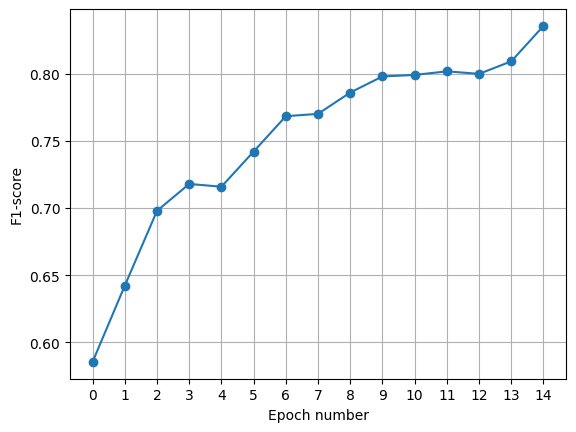

In [10]:
run(ResNet50_def(len(dataset.classes)))

Epoch 0: loss = 1.1317, time = 21.9701 s
Validation: loss = 1.1317, time = 14.2461 s, F1 score = 0.62756
Epoch 1: loss = 0.5765, time = 21.3459 s
Validation: loss = 0.5765, time = 14.2689 s, F1 score = 0.71522
Epoch 2: loss = 0.4553, time = 21.3113 s
Validation: loss = 0.4553, time = 14.4332 s, F1 score = 0.75475
Epoch 3: loss = 0.3938, time = 21.3143 s
Validation: loss = 0.3938, time = 14.2621 s, F1 score = 0.80075
Epoch 4: loss = 0.3214, time = 21.3216 s
Validation: loss = 0.3214, time = 14.1995 s, F1 score = 0.75951
Epoch 5: loss = 0.2967, time = 21.3459 s
Validation: loss = 0.2967, time = 14.1721 s, F1 score = 0.78835
Epoch 6: loss = 0.2841, time = 21.2094 s
Validation: loss = 0.2841, time = 14.1561 s, F1 score = 0.79562
Epoch 7: loss = 0.2468, time = 21.4037 s
Validation: loss = 0.2468, time = 14.2323 s, F1 score = 0.79809
Epoch 8: loss = 0.2500, time = 21.4760 s
Validation: loss = 0.2500, time = 14.0469 s, F1 score = 0.78904
Epoch 9: loss = 0.2126, time = 21.3317 s
Validation: lo

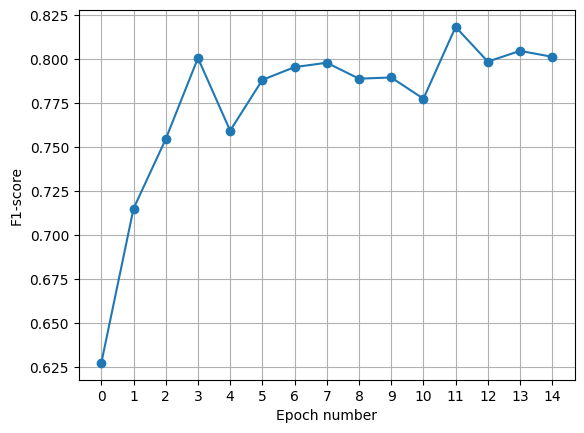

In [11]:
run(ResNet50_mod(len(dataset.classes)))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.6MB/s]


Epoch 0: loss = 1.4910, time = 39.5156 s
Validation: loss = 1.4910, time = 20.4300 s, F1 score = 0.40756
Epoch 1: loss = 1.0572, time = 38.1288 s
Validation: loss = 1.0572, time = 20.5447 s, F1 score = 0.51930
Epoch 2: loss = 0.8251, time = 38.4698 s
Validation: loss = 0.8251, time = 20.7991 s, F1 score = 0.56183
Epoch 3: loss = 0.6423, time = 38.5415 s
Validation: loss = 0.6423, time = 20.8790 s, F1 score = 0.61373
Epoch 4: loss = 0.4598, time = 38.5066 s
Validation: loss = 0.4598, time = 20.4698 s, F1 score = 0.64715
Epoch 5: loss = 0.4136, time = 38.6317 s
Validation: loss = 0.4136, time = 20.6412 s, F1 score = 0.61483
Epoch 6: loss = 0.3570, time = 38.3530 s
Validation: loss = 0.3570, time = 20.6650 s, F1 score = 0.63900
Epoch 7: loss = 0.3145, time = 38.5876 s
Validation: loss = 0.3145, time = 20.9856 s, F1 score = 0.46346
Epoch 8: loss = 0.4265, time = 38.5486 s
Validation: loss = 0.4265, time = 20.6817 s, F1 score = 0.66619
Epoch 9: loss = 0.3378, time = 38.4494 s
Validation: lo

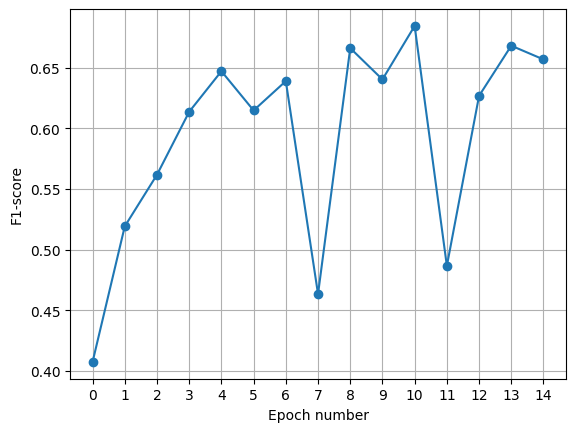

In [12]:
run(VGG16_def(len(dataset.classes)))

Epoch 0: loss = 1.0580, time = 39.0118 s
Validation: loss = 1.0580, time = 20.3435 s, F1 score = 0.59679
Epoch 1: loss = 0.5861, time = 38.3469 s
Validation: loss = 0.5861, time = 20.4714 s, F1 score = 0.70263
Epoch 2: loss = 0.3499, time = 38.4968 s
Validation: loss = 0.3499, time = 20.4672 s, F1 score = 0.74289
Epoch 3: loss = 0.2204, time = 38.3866 s
Validation: loss = 0.2204, time = 20.7376 s, F1 score = 0.76658
Epoch 4: loss = 0.1511, time = 38.3816 s
Validation: loss = 0.1511, time = 20.3798 s, F1 score = 0.80071
Epoch 5: loss = 0.0827, time = 38.3833 s
Validation: loss = 0.0827, time = 20.3544 s, F1 score = 0.78522
Epoch 6: loss = 0.0701, time = 38.5546 s
Validation: loss = 0.0701, time = 20.3670 s, F1 score = 0.80921
Epoch 7: loss = 0.0617, time = 38.3577 s
Validation: loss = 0.0617, time = 20.7209 s, F1 score = 0.80652
Epoch 8: loss = 0.0427, time = 38.3677 s
Validation: loss = 0.0427, time = 20.2995 s, F1 score = 0.80343
Epoch 9: loss = 0.0371, time = 38.3212 s
Validation: lo

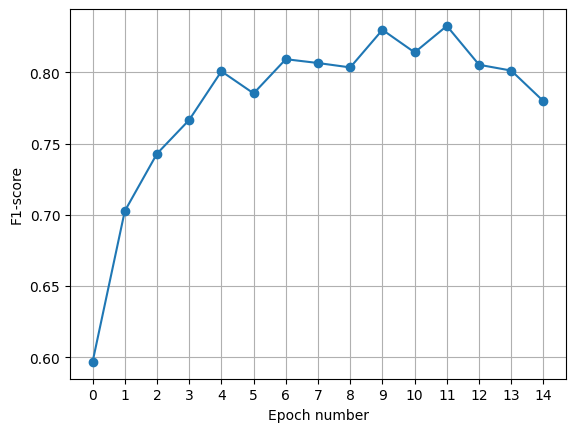

In [13]:
run(VGG16_mod(len(dataset.classes)))

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 140MB/s]


Epoch 0: loss = 1.5170, time = 14.1720 s
Validation: loss = 1.5170, time = 8.5548 s, F1 score = 0.52310
Epoch 1: loss = 1.1922, time = 13.8959 s
Validation: loss = 1.1922, time = 8.9117 s, F1 score = 0.55855
Epoch 2: loss = 1.0143, time = 13.8174 s
Validation: loss = 1.0143, time = 9.3261 s, F1 score = 0.59313
Epoch 3: loss = 0.8957, time = 13.8423 s
Validation: loss = 0.8957, time = 8.5429 s, F1 score = 0.61851
Epoch 4: loss = 0.8092, time = 13.9807 s
Validation: loss = 0.8092, time = 9.2753 s, F1 score = 0.62370
Epoch 5: loss = 0.7554, time = 14.0456 s
Validation: loss = 0.7554, time = 9.2324 s, F1 score = 0.67816
Epoch 6: loss = 0.7097, time = 14.3684 s
Validation: loss = 0.7097, time = 8.8081 s, F1 score = 0.63016
Epoch 7: loss = 0.6844, time = 14.5641 s
Validation: loss = 0.6844, time = 9.1985 s, F1 score = 0.69461
Epoch 8: loss = 0.6567, time = 14.5360 s
Validation: loss = 0.6567, time = 9.1652 s, F1 score = 0.69786
Epoch 9: loss = 0.6136, time = 14.4265 s
Validation: loss = 0.61

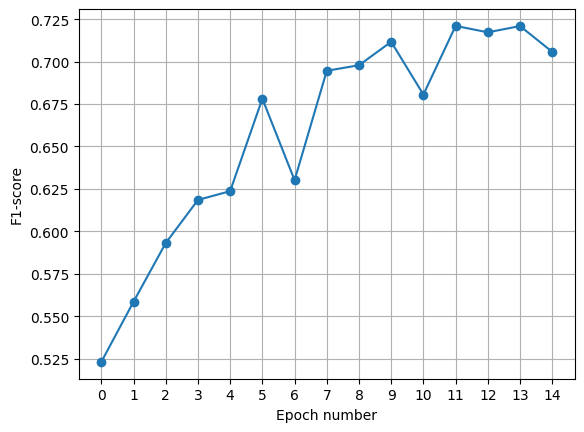

In [14]:
run(GoogleNet_def(len(dataset.classes)))

Epoch 0: loss = 0.7585, time = 14.5439 s
Validation: loss = 0.7585, time = 8.8024 s, F1 score = 0.74205
Epoch 1: loss = 0.2893, time = 13.8901 s
Validation: loss = 0.2893, time = 9.0120 s, F1 score = 0.78566
Epoch 2: loss = 0.1586, time = 13.7485 s
Validation: loss = 0.1586, time = 8.5274 s, F1 score = 0.84547
Epoch 3: loss = 0.1099, time = 13.4918 s
Validation: loss = 0.1099, time = 8.9917 s, F1 score = 0.78397
Epoch 4: loss = 0.0723, time = 14.3186 s
Validation: loss = 0.0723, time = 9.0254 s, F1 score = 0.82942
Epoch 5: loss = 0.0472, time = 14.2843 s
Validation: loss = 0.0472, time = 8.4598 s, F1 score = 0.81724
Epoch 6: loss = 0.0287, time = 14.1026 s
Validation: loss = 0.0287, time = 9.1566 s, F1 score = 0.84588
Epoch 7: loss = 0.0208, time = 13.9737 s
Validation: loss = 0.0208, time = 9.0141 s, F1 score = 0.83618
Epoch 8: loss = 0.0171, time = 14.1437 s
Validation: loss = 0.0171, time = 8.4819 s, F1 score = 0.83667
Epoch 9: loss = 0.0193, time = 13.0855 s
Validation: loss = 0.01

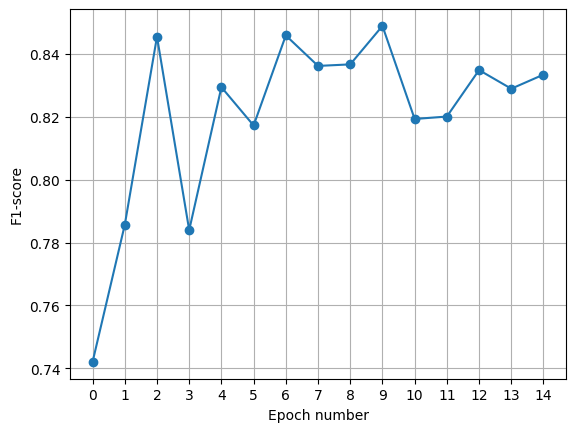

In [15]:
run(GoogleNet_mod(len(dataset.classes)))

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 119MB/s]


Epoch 0: loss = 1.7457, time = 13.7157 s
Validation: loss = 1.7457, time = 6.4315 s, F1 score = 0.17946
Epoch 1: loss = 1.6752, time = 13.5945 s
Validation: loss = 1.6752, time = 6.8807 s, F1 score = 0.25747
Epoch 2: loss = 1.6241, time = 13.8333 s
Validation: loss = 1.6241, time = 6.6632 s, F1 score = 0.36117
Epoch 3: loss = 1.5817, time = 13.7679 s
Validation: loss = 1.5817, time = 6.9910 s, F1 score = 0.48188
Epoch 4: loss = 1.5391, time = 13.7107 s
Validation: loss = 1.5391, time = 6.9307 s, F1 score = 0.50126
Epoch 5: loss = 1.5037, time = 13.4099 s
Validation: loss = 1.5037, time = 6.6309 s, F1 score = 0.50316
Epoch 6: loss = 1.4687, time = 13.4135 s
Validation: loss = 1.4687, time = 6.9079 s, F1 score = 0.53497
Epoch 7: loss = 1.4349, time = 13.7528 s
Validation: loss = 1.4349, time = 6.6230 s, F1 score = 0.54199
Epoch 8: loss = 1.4036, time = 13.5559 s
Validation: loss = 1.4036, time = 6.8569 s, F1 score = 0.54398
Epoch 9: loss = 1.3753, time = 13.5805 s
Validation: loss = 1.37

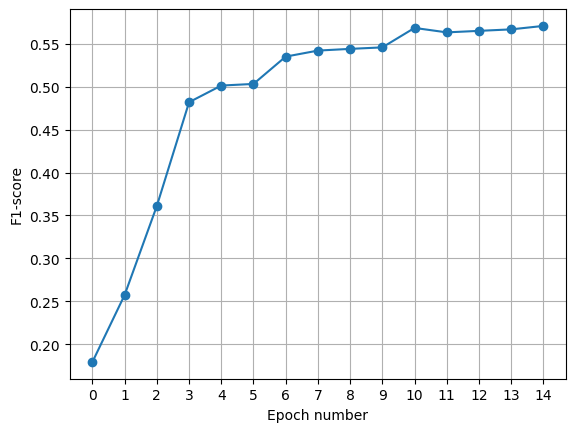

In [16]:
run(ShuffleNet_def(len(dataset.classes)))

Epoch 0: loss = 0.8181, time = 13.9937 s
Validation: loss = 0.8181, time = 6.9505 s, F1 score = 0.74650
Epoch 1: loss = 0.3832, time = 13.7799 s
Validation: loss = 0.3832, time = 6.7535 s, F1 score = 0.77406
Epoch 2: loss = 0.2849, time = 13.9973 s
Validation: loss = 0.2849, time = 7.2283 s, F1 score = 0.73569
Epoch 3: loss = 0.2134, time = 14.2246 s
Validation: loss = 0.2134, time = 6.5194 s, F1 score = 0.81831
Epoch 4: loss = 0.1745, time = 14.0158 s
Validation: loss = 0.1745, time = 7.1425 s, F1 score = 0.81660
Epoch 5: loss = 0.1624, time = 13.7190 s
Validation: loss = 0.1624, time = 6.3674 s, F1 score = 0.82158
Epoch 6: loss = 0.1459, time = 14.0004 s
Validation: loss = 0.1459, time = 6.9191 s, F1 score = 0.80030
Epoch 7: loss = 0.1322, time = 13.7096 s
Validation: loss = 0.1322, time = 6.7736 s, F1 score = 0.82532
Epoch 8: loss = 0.1111, time = 13.7841 s
Validation: loss = 0.1111, time = 6.9241 s, F1 score = 0.82867
Epoch 9: loss = 0.0963, time = 13.7051 s
Validation: loss = 0.09

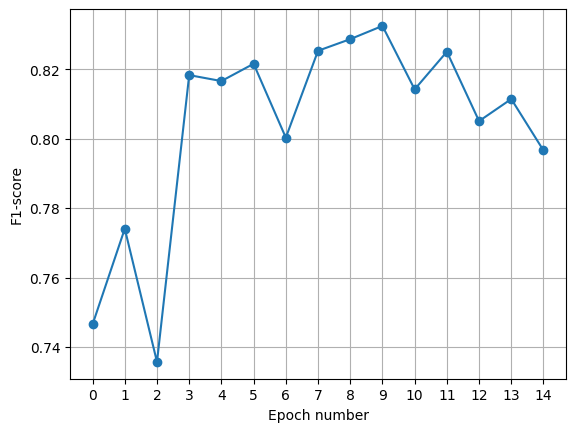

In [17]:
run(ShuffleNet_mod(len(dataset.classes)))

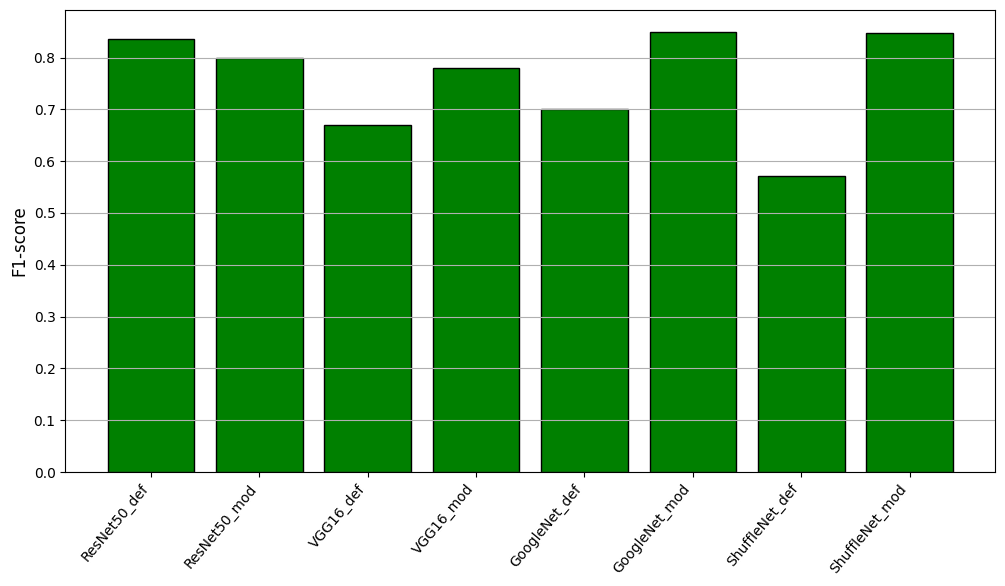

In [18]:
name_networks = [
    'ResNet50_def',
    'ResNet50_mod',
    'VGG16_def',
    'VGG16_mod',
    'GoogleNet_def',
    'GoogleNet_mod',
    'ShuffleNet_def',
    'ShuffleNet_mod']

plot.figure(figsize=(12, 6))
bars = plot.bar(name_networks, f1_test_table, color = 'green', edgecolor = 'black')
plot.ylabel('F1-score', fontsize = 12)
plot.xticks(rotation = 50, ha = 'right')
plot.grid(axis='y')
plot.show()